# Pairs Trading Strategy Design & Backtest v2025

## Part 0: Data Download & Preparation

In [1]:
# import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Custom modules to make notebook more organized
# from data_download import fetch_asset_data

from coint_tests import (
    johansen_sensitivity_summary, adf_results, kpss_results,
    engle_granger, engle_granger_bidirectional, za_test,
    analyze_regression_var_summary, analyze_johansen_triples,
    analyze_ecm_timeslices, analyze_error_correction_model
)
from pair_selection_summary import assemble_group_summary
from backtest import (
    generate_pair_pnl, run_and_score, run_vol_targeted_backtests
)
from plotting import plot_performance, analyze_pairs_nb

# Configuration to make table displays more readable
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.precision', 4)
pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x))
pd.options.display.float_format = lambda x: '{:.4f}'.format(x) if pd.notna(x) else '-'
np.set_printoptions(formatter={'float': lambda x: '{:.4f}'.format(x) if not np.isnan(x) else '-'})

In [2]:
# Utility function to format DataFrames for display
def format_df_for_display(df):
    """Format DataFrame for display with 4 decimals max and dashes for NaN"""
    formatted_df = df.copy()
    for col in formatted_df.select_dtypes(include=[np.number]).columns:
        formatted_df[col] = formatted_df[col].apply(
            lambda x: f'{x:.4f}' if pd.notna(x) else '-'
        )
    return formatted_df

# Smart formatting function that handles integers vs floats
def smart_format_value(x):
    """Format numeric values intelligently: integers as whole numbers, floats with max 4 decimals"""
    if pd.isna(x):
        return '-'
    
    # Check if it's effectively an integer (no fractional part)
    if isinstance(x, (int, np.integer)) or (isinstance(x, (float, np.floating)) and x == int(x)):
        return f'{int(x)}'
    else:
        # For floats, use up to 4 decimals but remove trailing zeros
        formatted = f'{x:.4f}'.rstrip('0').rstrip('.')
        return formatted if formatted else '0'

# Monkey patch DataFrame._repr_html_ to use smart formatting
original_repr_html = pd.DataFrame._repr_html_

def custom_repr_html(self):
    try:
        # Apply smart formatting for numeric columns
        display_df = self.copy()
        for col in display_df.select_dtypes(include=[np.number]).columns:
            display_df[col] = display_df[col].apply(smart_format_value)
        return display_df.to_html(escape=False, na_rep='-')
    except:
        # Fallback to original if there's any error
        return original_repr_html(self)

pd.DataFrame._repr_html_ = custom_repr_html

**Pairs Selection Rationale**

To start off I will take the apprach of downloading a larger set of pairs (and some potential tripples) to then perform a variety of tests on as a funneling approach to end up with the target 2-3 pairs for further study. The selected pairs (/tripples) were chosen based on own experience of the market and an understanding of pairs potentially linked by economic, quant, and event factors. I have tried to include a diverse set of asset classes and potential linkages, commodities, rates/FX, volatility, indices, equities, and sector ETFs. This broad and large set of pairs provide a good starting point and allows us to explore cointegrated relationship across a diverse range of assets. Below shows the initial list of potential cointegrated relationships, given that the source of these are my own experience following the market, these are based on my own biases and there is no guarantee they are actually cointegrated, which makes it all the more important we have a thorough approach to test these relationships.

**Pair/Triple Summaries**

- Precious Metals Triple (Gold, Silver, Platinum): These metals often move together due to their roles as stores of value and industrial inputs. Cointegration could be driven by  by macroeconomic cycles and investor sentiment.
- Oil Pair (WTI, Brent): WTI and Brent oil are different grades of oil and often trade closely together, supply/demand shocks can often temporarily dislocate their prices but they have a propensity to move back together to a more stable spread.
- Agri Pair (Corn, Soybean): Corn and soybean prices are linked by crop rotation, weather patterns, and global trade flows making them a potential candidate for cointegration.
- Yield Pair (US 10Y Yield, UK Gilts ETF): US and UK government bond yields are influenced by global interest rate cycles and monetary policy, often moving together, however dislocations can last a long time since rate decisions are not made that frequently, which could limit the potential trading opportunities.
- Currency Pair (AUD/USD, CAD/USD): Both AUD and CAD are commodity linked currencies with their exchange rates shaped by similar macroeconomic and trade factors.
- Volatility Pair (VIX, VIXY): The VIX index and VIXY ETF track US equity volatility the relationship is affected by futures curve dynamics and market stress regimes.
- EU Index Pair 1 (CAC 40, DAX): French and German equity indices are closely tied through European economic integration and cross border corporate activity.
- EU Index Pair 2 (IBEX 35, FTSE MIB): Similarly Spanish and Italian indices reflect Southern European market conditions often responding similarly to regional events.
- French Banking Pair (BNP Paribas, Societe Generale): Two major French banks with overlapping business models and exposure to the same regulatory environment.
- Fast Fashion Pair (Inditex, H&M): Leading European fast fashion retailers whose performance is shaped by consumer trends and global supply chains.
- German Auto Triple (VW, Mercedes, BMW): Germanys top automakers, sharing industry cycles, regulatory changes, and technological shifts.
- Investor AB Pair (Investor A, Investor B): Two share classes of the same Swedish investment company, expected to track closely due to identical underlying assets but with different voting rights.
- VW Porsche Pair (VW, Porsche AG): Linked through ownership structure and shared automotive sector exposure, VW owns circa 75% of Porsche.
- Semiconductor Pair (ASML, Infineon): European semiconductor firms with cointegration possible due to sector wide demand and supply chain factors.
- Sector ETF Pair (XLRE, XLU): US real estate and utilities ETFs, both considered defensive sectors and often moving together during risk off periods.


In [3]:
# Uncomment the two lines below to download data
 # end_date, start_date = datetime.now(), end_date - timedelta(days=5*365)

asset_groups = {
    "precious_metals_triple": ["GC=F", "SI=F", "PL=F"],    # Gold, Silver, Platinum Futures
    "oil_pair": ["CL=F", "BZ=F"],                          # WTI, Brent Crude Futures
    "agri_pair": ["ZC=F", "ZS=F"],                         # Corn, Soybean Futures
    "yield_pair": ["^TNX", "IGLT.L"],                      # US 10Y Yield, iShares UK Gilts ETF
    "currency_pair": ["AUDUSD=X", "CADUSD=X"],             # AUD/USD, CAD/USD
    "volatility_pair": ["^VIX", "VIXY"],                   # US VIX Index vs. Short-Term VIX Futures ETF
    "eu_index_pair_1": ["^FCHI", "^GDAXI"],                # CAC 40, DAX
    "eu_index_pair_2": ["^IBEX", "FTSEMIB.MI"],            # IBEX 35, FTSE MIB
    "fr_banking_pair": ["BNP.PA", "GLE.PA"],               # BNP Paribas, Societe Generale
    "fast_fashion_pair": ["ITX.MC", "HM-B.ST"],            # Inditex, H&M
    "german_auto_triple": ["VOW3.DE", "MBG.DE", "BMW.DE"], # VW, Mercedes, BMW
    "investor_ab_pair": ["INVE-A.ST", "INVE-B.ST"],       # Investor A, Investor B
    "vw_porsche_pair": ["VOW3.DE", "P911.DE"],             # VW, Porsche
    "semiconductor_pair": ["ASML.AS", "ASMI.AS"],          # ASML, ASM International
    "sector_etf_pair": ["XLRE", "XLU"]                     # Real Estate ETF, Utilities ETF
}

# Load data from CSV files
all_data = {}

for group_name in asset_groups.keys():
    filename = f'{'data'}/{group_name}_data.csv'
    df = pd.read_csv(filename, index_col=0, parse_dates=True)
    all_data[group_name] = df


## Part I: Pairs trade design. Preparatory cointegration analysis

Task 1: Recode regression estimation in matrix form. Implement Vector Autogregression specification tests for stability check using eigenvalue and identify optimal lag p using AIC/BIC

Task 2: Implement Engle-Granger (EG) for each pair using Augmented DF with lag=1 for the first part. For the second part write a short analysis including of the EC-term.

Task 3: Extend EG with a mean-reversion evaluation, enabeling trade design to enter on bounds $µ_e ± Zσ_eq$ and exit on $e_t$ reverting to the level $µ_e$.

Task 4: Optimize Z by e.g. vary in increments, producechart/table analyzing N trades and P&L for each level.

Task 5:  Present a short discussion of thoughts on structural breaks for the chosen asset groups. 

#### Task 1: Regression in matrix form, VAR optimal lag p, & Eigenvalues

For each pair we have (or for triples add columns accordingly):
$$
\mathbf{Pair} \,=\, 
\begin{pmatrix}
\vdots & \vdots & \vdots\\
y_{t} & x^{(1)}_{t} & x^{(2)}_{t}\\
\vdots & \vdots & \vdots
\end{pmatrix}
$$

We can specify $y$ to be the $T×1$ target vector and $X$ the $T×k$ design matrix (with intercept).The first column of $1$ is the intercept, $k$ is the number of regressors.:

$$
\mathbf{y} \,=\, \begin{pmatrix}y_1\\ \vdots\\ y_T\end{pmatrix} \in \mathbb R^{T\times1},\quad
\mathbf{X} \,=\, \begin{pmatrix}
1 & x^{(1)}_1 & x^{(2)}_1 & \cdots \\ 
\vdots & \vdots & \vdots & \\
1 & x^{(1)}_T & x^{(2)}_T & \cdots 
\end{pmatrix} \in \mathbb R^{T\times k}
$$

Our OLS estimator and fitted values then becomes:
$$ 
\hat{\boldsymbol\beta}= (\mathbf{X}^\top \mathbf{X})^{-1}\,\mathbf{X}^\top\,\mathbf{y},\quad
\hat{\mathbf{y}}=\mathbf{X}\,\hat{\boldsymbol\beta},\quad 
\hat{\boldsymbol\varepsilon}=\mathbf{y}-\hat{\mathbf{y}}
$$
We can look at the  $R^2$ as a crude indicator of co movement as an initial indicator of relationships to look into further for cointegration, but to confirm cointegration we must test the asset pars further.

When looking at the relationship between two time series there can be dynamic depenence that can add explanatory power to our model, or flipping the perspective we want to avoid residual autocorrelation so we don't miss out on signal. We can frame this relationship as there being $p$ previous periods we want to take into account in our model, in our case we have daily data so $p$ indicates how many days of data we want to incude in our model. If we have to few lags we bias inference while too many bias inference.

We can use a Vector Autoregressive model with order $p$ ($VAR(p)), we can express each variable (asset) as a linear function of its on $p$ past values, past $p$ values of other variables in the system as well as an error term. With intercept $c$ and estimates by multivariate OLS $VAR(p)$ for $n$ series:
$$
\mathbf{Y}_t \,=\, A_1\,\mathbf{Y}_{t-1} + \cdots + A_p\,\mathbf{Y}_{t-p} + \mathbf{c} + \varepsilon_t
$$

To find optimal lag $p$ we have several options we can use, AIC, BIC or even HQIC. These varyingly balance fit and parsimony for a VAR with log-likelihood $(\ell_p)$ and parameters $(K=n^2p+n)$:
$$
\begin{aligned}
\mathrm{AIC}(p) &= -2\,\ell_p + 2K,\\
\mathrm{BIC}(p) &= -2\,\ell_p + K\,\ln(T-p),\\
\mathrm{HQIC}(p) &= -2\,\ell_p + 2K\,\ln\!\big(\ln(T-p)\big).
\end{aligned}
$$
We will include all three in our analysis so we can then compare all 3 potential lags with the basecase of lag 1.

With optimal lag chosen, assess stability with eigenvalues via the companion matrix:
$$
\mathcal{F} = \begin{pmatrix}
A_1 & A_2 & \cdots & A_{p-1} & A_p \\
I_n & 0   & \cdots & 0        & 0   \\
0   & I_n & \cdots & 0        & 0   \\
\vdots &   & \ddots &          & \vdots\\
0   & 0   & \cdots & I_n      & 0
\end{pmatrix} \in \mathbb R^{np\times np}
$$
Stability if and only if all eigenvalues satisfy $max|\lambda_i|<1$ (see VAR section for notation).

In [4]:
# analyze_regression_var_summary performs a regression analysis on the provided asset groups and r^2 is calculated
# AIC/BIC/HQIC are calculated using the statsmodels VAR implementation.
# Eigenvalues are calculated using the best AIC fit lag
reg_var_summary = analyze_regression_var_summary(all_data)
reg_var_summary

,group,r_squared,best_aic,best_bic,best_hqic,eigenvalues
0,precious_metals_triple,0.8442,7,1,2,2.147 2.147 1.863 1.863 1.790 1.790 1.665 1.665 1.591 1.533 1.533 1.529 1.529 1.502 1.502 1.442 1.442 1.345 1.016 1.016 0.998
1,oil_pair,0.9916,9,2,2,1.532 1.532 1.444 1.444 1.411 1.411 1.346 1.346 1.290 1.290 1.267 1.267 1.242 1.242 1.225 1.225 1.036 1.006
2,agri_pair,0.8049,1,1,1,1.019 1.004
3,yield_pair,0.9335,3,2,2,5.506 3.690 3.616 3.616 1.008 1.003
4,currency_pair,0.8363,4,1,2,4.089 2.849 2.849 2.427 2.427 2.422 1.011 1.004
5,volatility_pair,0.2209,8,3,3,1.719 1.658 1.658 1.655 1.655 1.517 1.507 1.507 1.419 1.419 1.383 1.383 1.302 1.302 1.042 1.005
6,eu_index_pair_1,0.5988,1,1,1,1.006 0.998
7,eu_index_pair_2,0.955,1,1,1,1.010 1.000
8,fr_banking_pair,0.7718,1,1,1,1.004 0.995
9,fast_fashion_pair,0.2451,2,1,1,38.216 23.183 1.011 1.001


Only 6 of the asset groups have the same optimal AIC, BIC and HQIC (all of those 6 have optimal lags at 1 for all methods), the varying lags of the other asset groups could be an indication of shifting relationship across the series for those assets. In terms of Eigenvalues almost no values are below 1, no asset group has all eigenvalues below 0. However a lot of asset groups have eigenvalues just around 1. In terms of $r^2$ there seems to be very strong relations in the oil, yield, EU index pair 2, and the investor pair. Except for investor (and partly german auto makers) the equity groups had low $r^2$. Also volatility had a surprislingly low $r^2$. Non of these tests are themselves conclusive regarding cointegration of the asset groups but the give is nuance and context that will be helpful in our further exploration of these relationships

#### Task 2: Engle-Granger (+ bonus Johansen) & analysis of EC term

With the initial exploration done we can move on with explicitly testing for stationarity using ADF and KPSS which will allow us to move on to the Engle-Granger procedure (as well as the Johansen procedure for triples). The following decision thresholds will be used for the 4 tests:

| Test       | Null (H₀)                               | Alternative (H₁)          | α-Level |
|------------|-----------------------------------------|---------------------------|---------|
| ADF        | Non-stationarity (unit root)            | Stationarity              | 5%      |
| KPSS       | Stationarity                            | Unit root                 | 5%      |
| EG Step 2  | No cointegration (β_ec=0)               | Cointegration (β_ec≠0)    | 5%      |
| Johansen   | ≤ r cointegration vectors               | > r cointegration vectors | 5%      |

L:et's now go over the 4 tests in detail before we impplement them. We will start with the 2 tests for staionarity.

Each asset individually is tested for stationarity using the Augmented Dickey–Fuller (ADF) and KPSS tests. A time series $X_t$ is (weakly) stationary if its mean, variance, and autocovariance do not change over time. Financial series are often non-stationary and exhibit unit roots. A process is said to be integrated of order one, $I(1)$, if differencing once yields a stationary series. Here we will be differencing by looking at all assets in the given group at a time, for pairs we look at this using Engle Granger and if we have more assets we can use the Johansen procedure. If the differences series is stationary we say it is $I(0)$.

##### ADF test

ADF tests the null of a unit root (non-stationarity) against the alternative of stationarity, via the regression:
$$
\Delta X_t = \gamma X_{t-1} + \sum_{i=1}^{p} \phi_i \, \Delta X_{t-i} + \varepsilon_t,
$$  
where $\Delta X_t = X_t - X_{t-1}$. If $X_t$ has a unit root, then $\gamma = 0$. If $X_t$ is stationary we expect $\gamma < 0$. The test statistic for $\hat{\gamma}$ is compared to ADF $α$ critical value of 5%.

##### KPSS test

KPSS reverses the hypotheses:  

$$
H_0: \text{stationary (around a level or trend)} \quad\text{vs.}\quad H_1: \text{unit root}.
$$  

It assesses whether residuals from a regression on a constant or trend exhibit a random-walk component.


If ADF rejects $H_0$ (unit root) and KPSS fails to reject $H_0$ (stationarity) both point to stationarity, giving us confidence we have a stationary series. Conflicting results could suggest trend stationarity or mixed evidence, this would warrante further investigate specification (e.g., include a trend), lag length, or structural breaks.


In [5]:
# ADF & KPSS are calculated using the statsmodel implementation
data_pairs = [(group, asset, df[asset]) for group, df in all_data.items() for asset in df.columns]

results = pd.DataFrame([
    {
        'Group': group,
        'Asset': asset, 
        'ADF_pval': adf_results(series)['pvalue'],
        'KPSS_pval': kpss_results(series)['pvalue']
    }
    for group, asset, series in data_pairs
])

results['Status'] = np.where(
    (results['ADF_pval'] < 0.05) & (results['KPSS_pval'] >= 0.05), 'Stationary',
    np.where(
        (results['ADF_pval'] >= 0.05) & (results['KPSS_pval'] < 0.05), 'Non-stationary', 
        'Mixed'
    )
)

results

,Group,Asset,ADF_pval,KPSS_pval,Status
0,precious_metals_triple,GC=F,0.9991,0.01,Non-stationary
1,precious_metals_triple,PL=F,0.1353,0.0724,Mixed
2,precious_metals_triple,SI=F,0.9636,0.01,Non-stationary
3,oil_pair,BZ=F,0.219,0.01,Non-stationary
4,oil_pair,CL=F,0.1344,0.01,Non-stationary
5,agri_pair,ZC=F,0.3894,0.01,Non-stationary
6,agri_pair,ZS=F,0.4923,0.01,Non-stationary
7,yield_pair,IGLT.L,0.4165,0.01,Non-stationary
8,yield_pair,^TNX,0.4666,0.01,Non-stationary
9,currency_pair,AUDUSD=X,0.515,0.01,Non-stationary


As expected non of the individual assets have strong evidence of stationarity. However a handful of assets passed 1 of the tests but not the others, assets trading flat, which is common for volatility index, commodities and even some stocks is not uncommon over some time periods so it is not too surprising we are getting the mixed result. Overall we can draw the conclusion there is no strong evidence of stationarity in any of the individual assets for the given time period. This leads us into the EG (and Joahnson procedure) can we now difference these assets to create combined series that is stationary and therefore cointegrated.

##### Engle–Granger Cointegration Test (Pairs)

Engle Granger (EG) tests of a linear combination of two (or more) nonstationary series is stationary i.e., whether they are cointegrated and share a common stochastic trend. As per the exam instructions we will use maxlag=1 but it will also be interesting to compare lag $p$ 1 with the different max lags we got from our VAR analysis previously.

If we et $Y_t$ and $X_t$ each be $I(1)$. If there exists $\beta$ such that $u_t = Y_t - \beta X_t$ is $I(0)$, then $Y_t$ and $X_t$ are cointegrated. To test this we use the EG two step procedure:

1. Estimate the cointegrating relationship
   $$
   Y_t = c + \beta X_t + u_t,
   $$  
   using OLS to obtain $\hat{c} $, $\hat{\beta}$, and residuals $\hat{u}_t$. We can interprete the $\hat{\beta}$ as the hedge ratio.

2. Test residual stationarity 
   Apply the ADF to test $\hat{u}_t$. If $\hat{u}_t$ is stationary ($I(0)$)we conclude cointegration between $Y_t$ and $X_t$. And we use the same EG-specific critical values from above of 5%.

A couple of caveats with EG is that results can differ depending on which variable is treated as dependant in the OLS. We are also limited by one cointegration vector and need to use Johansen if we want to test for more.

In [6]:
# Initialize results dictionary 
all_results = {}

# Filter to pair groups only
pair_groups = reg_var_summary[reg_var_summary['group'].str.endswith('_pair')].copy()

for _, row in pair_groups.iterrows():
    group = row['group']
    df = all_data[group]
    y, x = df.columns[:2]
    
    # Get lag lengths
    lag_lengths = {
        'aic': row['best_aic'], 
        'bic': row['best_bic'], 
        'hqic': row['best_hqic']
    }
    
    # Run baseline and alternative tests
    pair_results = {'baseline': engle_granger(df, y, x, maxlag=1)}
    
    # Add alternative lag tests only where different from baseline
    for criterion, lag in lag_lengths.items():
        if lag != 1:
            pair_results[criterion] = engle_granger(df, y, x, maxlag=lag)
    
    all_results[group] = pair_results

comparison_data = [
    {
        'Pair': group,
        'Criterion': criterion,
        'Max Lag': result['maxlag'],
        'Hedge Ratio': result['beta'],
        'P-value': result['eg_pvalue'],
        'Cointegrated': result['eg_pvalue'] <= 0.05
    }
    for group, results in all_results.items()
    for criterion, result in results.items()
]

pd.DataFrame(comparison_data)

,Pair,Criterion,Max Lag,Hedge Ratio,P-value,Cointegrated
0,oil_pair,baseline,1,1.0253,0,True
1,oil_pair,aic,9,1.0253,0.0003,True
2,oil_pair,bic,2,1.0253,0,True
3,oil_pair,hqic,2,1.0253,0,True
4,agri_pair,baseline,1,0.4899,0.0145,True
5,yield_pair,baseline,1,-1.0173,0.1538,False
6,yield_pair,aic,3,-1.0173,0.1905,False
7,yield_pair,bic,2,-1.0173,0.1655,False
8,yield_pair,hqic,2,-1.0173,0.1655,False
9,currency_pair,baseline,1,1.2746,0.0216,True


The oil pair exhibits cointegration across all lags, the agri pair had optimal p=1 for all methods and also shows cointegration on p=1. Currency pair shows cointegration on some lags not others. And volatiltu pair also shows cointegration across all ps. The rest of the pairs show no cointegration, the lack of cointegration for the different Investor share classes is surprising, each different shareclass entitle the holder to the same stake in the company, only voting rights are different, my initial hypothesis would have been that this one would have the strongest cointegration, it would be interesting to dive deeper into this pair to investigate why above tests did not find cointegration to see if there really is no cointegration or if it is possible to use different model parameters to prove the cointegration but that is outside the scope of this paper. For now, oil, agri, currency and volatility are the 4 pairs that look most promising.

Next lets analyze the error correction terms using the Error Correction Model (ECM), we estimate the ECM parameters to quantify adjustment to equilibrium deviations.

For a cointegrated series Y and X with residual $(u_{t-1}=Y_{t-1}-\beta X_{t-1})$, the discrete ECM is:

$$\Delta Y_t = \alpha\,u_{t-1} + \sum_{i=1}^{p-1} \phi_i\,\Delta Y_{t-i} + \sum_{i=1}^{p-1} \psi_i\,\Delta X_{t-i} + \eta_t,$$

the $\alpha$ is the error correction coefficient (which we can interprete as the adjustment speed back to equilibrium)


In [7]:
# Run ECM on the 4 cointegrated pairs
pairs = ['oil_pair', 'agri_pair', 'currency_pair', 'volatility_pair']
ecm_results = {}

for pair in pairs:
    df = all_data[pair]
    y, x = df.columns[:2]
    eg = engle_granger(df, y, x)
    ecm_results[pair] = analyze_error_correction_model(df[y], df[x], eg['spread'])

pd.DataFrame(ecm_results).T

,ecm_coeff,ecm_pvalue
oil_pair,-0.0827,0
agri_pair,-0.0144,0.0027
currency_pair,-0.0156,0.0012
volatility_pair,-0.0059,0


All pairs show negative coefficients which confirms cointegration (mean reversion), the higher (absolute) the value the quicker the mean reversion so we can see that oil reverts relativly quickly while volatility is the slowest to revert (we could interprete this as volatility clustering, periods of high/low periods tend to last a while). We can further the ECM analysis by splitting the dataset into subperiods to check if the coefficients stay the same across different subperiods. Below code splits the data into 5 equal length periods and performs the same ecm analysis. For each time slicerun OLS dep ~ 1 + reg to get the local cointegrating residual $u_t$, then run ECM $Δdep_t ~ c + [Δreg_t] + u_{t-1}$. The coefficient on $u_{t-1}$ is the ecm_coeff and its p-value is ecm_pvalue. It tries both directions (y|x and x|y) and returns the direction with stronger adjustment (prefers negative coeff with lower p-value). 

We can now move on to testing the triples with the the Johansen procedure tests by estimating a VECM and the rank of itthes long run coefficient matrix $\Pi = \alpha\beta'$. If $\Pi$ has reduced rank $r$, there are $r$ independent cointegrating vectors. We use two likelihood ratio tests, the trace test and the maximum eigenvalue test to determine $r$. 

The trace test checks the null hypothesis that there are at most $r$ cointegrating relations against the alternative of more than $r$. It computes $-T \sum_{i=r+1}^{n}\ln(1-\hat\lambda_i)$, which accumulates the eigenvalues $\hat\lambda$ beyond rank $r$, if this exceeds the critical value we reject $H_0$ and conclude that at least $r+1$ cointegrating vectors exist.

The max-eigen test considers the null of exactly $r$ cointegrating vectors Vs $r+1$ and focuses on the next eigenvalue $-T\ln(1-\hat\lambda_{r+1})$. By increasing $r$ from 0 upward and applying these tests we find the estimated cointegration rank $\hat r$.

With Johansen test we get an estimate of the cointegrating vector $\beta$ via the top eigenvector which we can use to form a stationary spread e.g. $w_1 X_{1t} + w_2 X_{2t} + w_3 X_{3t}$ that mean-reverts. For below implementation we use the optimal lag length $p$ identified from the previous VAR analysis.

In [8]:
johansen_df = analyze_johansen_triples(all_data)
johansen_df

,triple,n_assets,n_coint_relations,first_eigenvec_norm,spread_vol,data_points
0,precious_metals_triple,3,0,0.6662,-,1305
1,german_auto_triple,3,0,0.2251,-,1305


There are no cointegrated relationships from the Johansen test, to explore why this might we can run some sensativity analysis to get any idea of why got this result. Using deterministics det_order $∈ {-1, 0, 1, 2}$ and trying all three different AIC/BIC/HQIX optimal lags we get 12 different specifications per windows we also use weekly sampling (W-FRI) to reduce roll/noise, log-levels to stabilize variance subperiod slices to mitigate regime breaks again using r > 0 at 5% as the critical decision threshold.

In [9]:
# Johansen sensitivity summary

summary = johansen_sensitivity_summary(all_data)
summary

,triple,window,rank>0,total,summary
4,german_auto_triple,H1,0,12,0/12
5,german_auto_triple,H2,8,12,8/12
3,german_auto_triple,full,0,12,0/12
1,precious_metals_triple,H1,8,12,8/12
2,precious_metals_triple,H2,6,12,6/12
0,precious_metals_triple,full,3,12,3/12


The german auto tripple shows now rank > 1 for the f first nor full window but does show rank > 1 for the second time window. This means there likeley was a structural change, trends in EV, auto worker strikes and tarrifs could mean the tripples were strongly cointegrated in the second time window whereas the first time window might have been driven more by company specific factors. The precious metal tripple shows stronger indication of cointegration, both window periods show stronger cointegration 6/8 than the full sample that showed 3, this is also an indication that  there are probably structural changes happening and that the full sample dilutes the signal. Given the weak signs of cointegration for triples we will not keep any of them for further analysis and will instead continue with the pairs we have left. We had 4 pairs with strong sign of cointegration but it would also be interesting to look at subperiod relatinships for those pairs, since we already have strong indication of cointegration for the whole period we will break down the slices here more granularly by doing 5 slices, approx 1 year per slice.

In [10]:
timeslice_tables = {
    pair: analyze_ecm_timeslices(all_data[pair].iloc[:, 0], all_data[pair].iloc[:, 1], periods=5)
    for pair in pairs
}

pd.concat(timeslice_tables, axis=0)

P1      P2      P3      P4      P5
oil_pair        ecm_coeff  -0.0865 -0.1620 -0.1038 -0.1749 -0.1330
                ecm_pvalue  0.0008  0.0000  0.0002  0.0000  0.0000
agri_pair       ecm_coeff  -0.0377 -0.0304 -0.0774 -0.0482 -0.0582
                ecm_pvalue  0.0278  0.0671  0.0001  0.0049  0.0078
currency_pair   ecm_coeff  -0.0270 -0.0918 -0.0312 -0.0260 -0.0492
                ecm_pvalue  0.0537  0.0005  0.0220  0.0412  0.0146
volatility_pair ecm_coeff  -0.0762 -0.0289 -0.0771 -0.0439 -0.1177
                ecm_pvalue  0.0008  0.0002  0.0001  0.0034  0.0000

Oil shows strong mean reversion with episodes of accelerated adjustment (P2, P4). Agri was small but significant for single period, slices mostly significan, adjustment strengthened after P2. Currency adjustment is present throughout but much stronger from P2 onward, full sample is diluted by the weaker first slice. Volatility (VIX vs VIXY) single period very small (-0.0059) but significant. Consistently strong mean reversion by slice, full sample probably underestimates speed because per slice estimation captures time-varying β and dynamics.

The slice re-estimate of the cointegrating allow the adjusting leg to switch (direction pick), and include ΔX. This reduces misspecification and reveals time variation in both β and adjustment speed, so per slice alphas are stronger and more consistent. To further focus the analysis we will drop the agri pair and continue with the other 3 pairs.

##### Task 3: Extending EG with a third step for mean reversion evaluation


We will extend EG with a trading rule, enter at $μ_e ± Z·σ_e$ and exit when the spread reverts to $μ_e$. For each pair we have run EG and gotten the hedge ratio β and residual spread $S_t = Y_t - β X_t$. We can then use the Ornstein-Uhlenbeck (OU) process SDE:

$$dS_t=\theta(\mu-S_t)\,dt+\sigma\,dW_t,$$
which we discretize to an AR(1):
$$S_{t+1}=\mu_e+\rho(S_t-\mu_e)+\varepsilon_t,\quad \rho=e^{-\theta\Delta t}.$$

We fit the AR(1) model to $S_t$ to estimate $\rho$, set $\theta = -\ln(\rho)$, and compute $\mu_e$ and $\sigma_e$ to define the Z bands. Our signal is:
$$z_t = \frac{S_t - \mu_e}{\sigma_e}.$$

With the signal in place we set the trading rules:
Entry:
- Short spread when $z_t \ge Z$ (short Y, long $\beta$ units of X).
- Long spread when $z_t \le -Z$ (long Y, short $\beta$ units of X).

Exit:
- Close when $|z_t| \le 0$ (i.e., on reversion to $\mu_e$).

##### Task 4: Find optimal Z

We want to find some optimal value of $Z$ which we can do simply by sweeping $Z \in [0.5, 3.0]$ in steps of 0.1. The implementation below normalizes PnL on $\Delta z_t$ to make pairs comparable and applies a cost of 0.002 on position changes. We report $N$ trades, cumulative PnL, and average PnL, and select $Z$ by maximizing cumulative PnL.

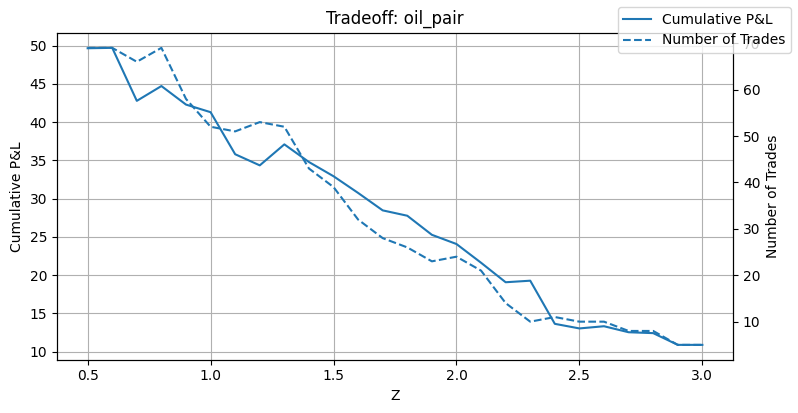

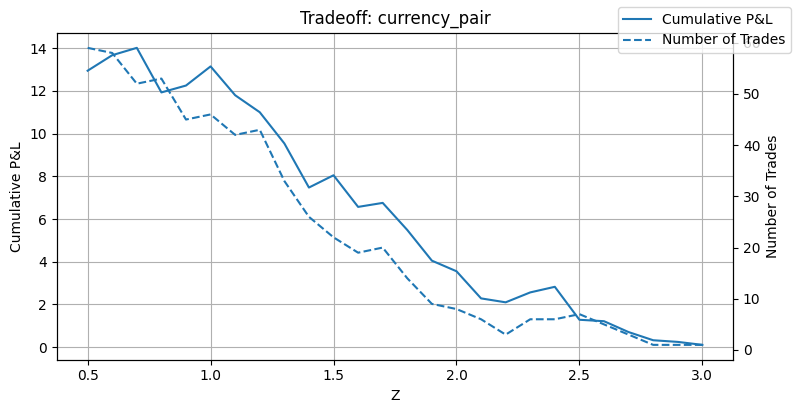

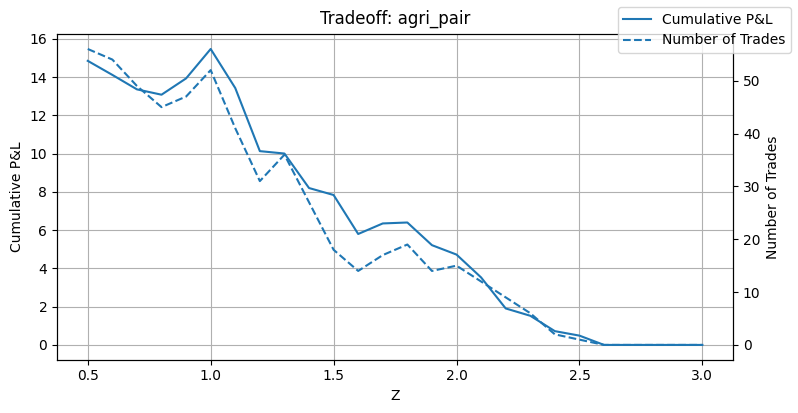

,pair,best_Z,N_trades,cum_PnL,avg_PnL
0,oil_pair,0.6,69,49.697,0.7202
1,currency_pair,0.7,52,14.0157,0.2695
2,agri_pair,1,52,15.465,0.2974


In [11]:
# choose pairs
selected = ['oil_pair', 'currency_pair', 'agri_pair']

# sweep Z from 0.5 to 3.0 in 0.1 steps; include costs
summary_df, opt_tables = analyze_pairs_nb(
    all_data, selected,
    Z_min=0.5, Z_max=3.0, dZ=0.1,
    cost=0.002,
    normalize=True
)
summary_df

Results are in normalized (z) units (matters for agri pair which would otherwise not be comparable) so magnitudes are comparable across asset classes.

Oil shows tightest optimal band and highest trade count showing strong, frequent mean reversion. N_trades vs Z fall steeply peaks around 0.5–0.6 then declines as signals get too sparse. Avg_PnL per trade rises with Z but total cum peaks earlier due to fewer trades.
Currency shows moderate edge, more cost-sensitive. Optimal Z slightly wider than oil.
Graph is slightly flatter cum_PnL curve with a gentle hump near 0.7. Agri pair needs wider entry to overcome noise/roll effects, edge is comparable to currency once normalized.

##### Task 5: Structural break risk discussion

Structural breaks matter because our cointegration and mean-reversion framework (EG residual stationarity, ECM, and OU/AR(1) dynamics) assumes stable long run equilibrium and adjustment speed. Our ECM time slice study already gave some proof of time varying relations. Oil showed episodic acceleration (P2, P4), currency strengthened after P2, and volatility (VIX–VIXY) had a small but significant full sample α while slices were consistently stronger. Shifts like these imply that $β$, $μ_e$, $σ_e$, and $ρ$ can drift across regimes, changing OU half-life and Z-band effectiveness. For oil structural breaks could arise from things such as logistics and policy changes (pipeline flows, export/import policies, OPEC shifts) that permanently alter the differential relation. AUD and CAD currency policy divergence and terms-of-trade shocks could decouple the commodity currency linkage, this commodity related economy relationship could change as dependence on certain commodies shift. VIX–VIXY term structure regimes (contango/backwardation) could change ETF roll-yield drag and tracking, weakening residual stationarity even if short windows still look mean reverting.

We can use tool such as ZA (Zivot–Andrews) to identify and flag endogenous breakpoints. ZA reestimates EG/β and OU/AR(1) parameters on rolling windows (as in our time-slice ECM) so $μ_e$ and $σ_e$ for $z_t$ adapt and conduct walk forward Z-sweeps since $Z_best$ can drift with costs and adjustment speed. We could then include guards like halting trading when EG residual ADF p-values rise, widening $Z_exit$ temporarily if half-life lengthens, and using a time-varying β (e.g., Kalman) to cushion slow drifts. This would keep our trading strategy aligned with the evolving equilibrium identified by the EG/ECM and OU mappings.

In [12]:
results = []
for pair in selected:
    df = all_data[pair]
    y, x = df.columns
    eg = engle_granger_bidirectional(df, y, x)
    spread = eg['spread'].dropna()

    results.append(za_test(spread, model='level').assign(pair=pair))
    results.append(za_test(spread, model='trend').assign(pair=pair))

pd.concat(results, ignore_index=True)

,stat,pvalue,breakpoint,break_date,model,pair
0,-6.6454,0.0002,22,2020-09-09,level,oil_pair
1,-6.6274,0.001,22,2020-09-09,trend,oil_pair
2,-4.9824,0.0307,1,2020-08-11,level,currency_pair
3,-5.0019,0.0625,1,2020-08-11,trend,currency_pair
4,-4.8639,0.044,0,2020-08-10,level,agri_pair
5,-5.4457,0.017,0,2020-08-10,trend,agri_pair


The ZA results indicate strong evidence of stationarity with a structural break for oil_pair under both specifications (level and trend) on 2020-09-09 suggesting a robust break in the mean and not undermined by adding a trend. For currency_pair, stationarity is supported only under a level break but not when a trend break implying the break is primarily in the intercept. For agri_pair both models show a breakpoint at the start (0) implying an early-sample structural shift. August/September was an intense period for the world and the market, covid was a major factor, it is perhaps to too surprising that the the strongest breaks in this timeframe occured roughly at the same time for all three pairs.


## Part II: Backtesting

Task 6: ML/Scikit-learn inspirired backtesting of trading strategy e.g. split data into train/test set.

Task 7: Systematic backtesting, produce drawdown, rolling sharpe, and rolling beta (vs S&P 500) plots and discuss plots.

Task 8: Discuss benefits and disadvantages of regular re-estimation of cointegrated
relationships: 5-8 months rolling window shifting by 10-15 days.

Optional/bonus task: Kalman filter for adaptive re-estimation of EG step 1

##### Task 6: Splitting train/test data and backtesting trading strategy

##### Risk Management Considerations

- Stop-loss on extreme Z to cap losses if divergence persists.
- Drawdown stop based on backtested peak-to-trough limits.
- Structural break guard: rolling re-estimation (β, μ); halt if cointegration weakens.
- Transaction costs: include realistic costs; optional Kalman β for adaptability.

Rolling out-of-sample backtest with walk-forward optimization: train thresholds, then test performance.
- Windows: 18m train, 6m test, 3m step.
- Metrics: Sharpe, P&L, trade count across Z values.

## Backtesting analysis (in-sample & out-of-sample)